# Assignment1

1. Simple numpy exercises.
2. Implement K-nearest-neighbor with numpy.

If you are not sure about some api, search their document. E.g., NumPy manual https://numpy.org/doc/stable/

In [28]:
import sys, os, platform
print("Executable:", sys.executable)
print("Python version:", sys.version)
print("CWD:", os.getcwd())
print("Platform:", platform.platform())

Executable: d:\PROGRAMMING\.conda\python.exe
Python version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
CWD: d:\PROGRAMMING\Multimedia\Assignment1\notebooks
Platform: Windows-10-10.0.26100-SP0


## 1.Simple Numpy Exercise

In [29]:
import numpy as np
np.random.seed(1)
#### 1. How to find the most frequent value in an array?
Z = np.random.randint(0,10,50)
print(Z)
########### less than two lines ###########
##### Hint: argmax, bincount ##############
# 统计每个数字出现次数后取出现次数最大的索引
answer = np.bincount(Z).argmax()
##### answer should be 9 ##################
###########################################
print(answer)


[5 8 9 5 0 0 1 7 6 9 2 4 5 2 4 2 4 7 7 9 1 7 0 6 9 9 7 6 9 1 0 1 8 8 3 9 8
 7 3 6 5 1 9 3 4 8 1 4 0 3]
9


In [30]:
#### 2. Consider a small/medium/large vector Z, compute Z to the power of 3 using 3 different methods
#### search how to use np.einsum ####
np.random.seed(1)
# 为了避免你机器直接分配 5e7 (需要约 400MB+ 内存) 这里示范小一点的向量，再给出可扩展写法
N = int(5e5)  # 如果你想真实对比性能，可改回 5e7 (注意内存与时间)
x = np.random.rand(N)

# A: np.einsum -> x*x*x 等价于三次相乘
%timeit np.einsum('i,i,i->i', x, x, x)
# B: np.power
%timeit np.power(x, 3)
# C: 逐元素乘法 (向量化)
%timeit x * x * x

# （可选扩展）如果需要保持内存复用，写入同一个数组：
# y = x.copy(); np.multiply(x*x, x, out=y)


1.2 ms ± 41.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.5 ms ± 106 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.5 ms ± 106 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.78 ms ± 35.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.78 ms ± 35.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
#### 3. Create random vector of size 10 and replace the maximum value by 0
np.random.seed(1)
Z = np.random.random(10)
# your solution in one line, hint: use argmax and indexing
Z[Z.argmax()] = 0  # 就地修改
answer = Z
print(answer)
# answer should be
#  [4.17022005e-01 0.00000000e+00 1.14374817e-04 3.02332573e-01
#  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
#  3.96767474e-01 5.38816734e-01]


[4.17022005e-01 0.00000000e+00 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]


In [32]:
#### 4. Normalize a 5x5 random matrix
#### normalize: (x - μ) / σ
np.random.seed(1)
Z = np.random.random((5,5))
# your solution in one line, hint: use np.mean, np.std
answer = (Z - Z.mean()) / Z.std()
print(answer)
# answer should be: 
# [[-0.08166511  1.00240927 -1.57179097 -0.4915921  -1.04765972]
#  [-1.24215993 -0.906462   -0.33708451 -0.15405956  0.35365788]
#  [-0.07390005  0.87693577 -0.84143938  1.56639833 -1.47431007]
#  [ 0.82420869 -0.08065433  0.42468899 -1.07042386 -0.86413849]
#  [ 1.28984952  1.88859468 -0.45194809  0.90232398  1.56022104]]


[[-0.08166511  1.00240927 -1.57179097 -0.4915921  -1.04765972]
 [-1.24215993 -0.906462   -0.33708451 -0.15405956  0.35365788]
 [-0.07390005  0.87693577 -0.84143938  1.56639833 -1.47431007]
 [ 0.82420869 -0.08065433  0.42468899 -1.07042386 -0.86413849]
 [ 1.28984952  1.88859468 -0.45194809  0.90232398  1.56022104]]


## 3.Implement KNN with NumPy

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

# 从零开始下载数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [34]:
# CIFAR-10的分类标签
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_samples = 5

# 为每个类别获取10个样本
def get_samples_per_class(data, num_samples=10):
    samples = {cls: [] for cls in range(len(classes))}
    
    for img, label in zip(data.data, data.targets):
        if len(samples[label]) < num_samples:
            samples[label].append(img)
        # 当所有类都满足数量要求时，结束
        if all(len(samples[cls]) == num_samples for cls in samples):
            break
    
    return samples
    
# 获取每个类10个样本
samples = get_samples_per_class(trainset, num_samples)

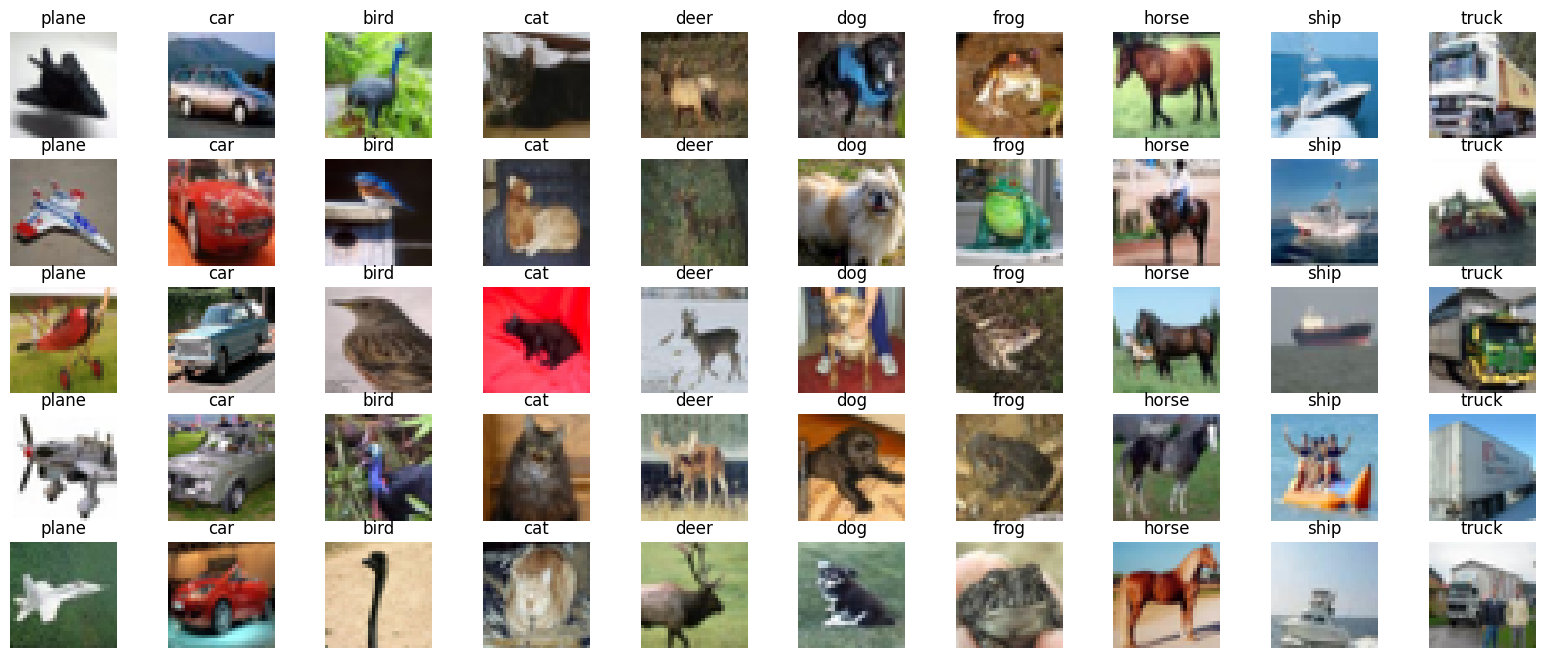

Training data shape: 50000
Test data shape: 10000


In [35]:
# 绘制N(类别数) x 10 的figure，标注label
def plot_samples(samples, num_classes=len(classes), samples_per_class=10):
    fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(num_classes+10, samples_per_class+3))
    for i, (cls, imgs) in enumerate(samples.items()):
        for j, img in enumerate(imgs):
            ax = axes[j, i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(classes[cls])
    plt.show()
# 显示样本图像
plot_samples(samples, samples_per_class=num_samples)
# imshow(torchvision.utils.make_grid(images))
# # 打印标签
# print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

# 打印训练集和测试集的大小
print(f'Training data shape: {len(trainset)}')
print(f'Test data shape: {len(testset)}')

In [36]:
X_train, y_train = trainset.data[:5000], np.array(trainset.targets[:5000], dtype=int)
X_test, y_test = testset.data[:500], np.array(testset.targets[:500])
X_train = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
X_test = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
X_train = X_train / 256.
X_test = X_test / 256.

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label.

Lets begin with computing the distance matrix between all training and test examples.

For example, if there are Ntr training examples and Nte test examples, this stage should result in a Nte x Ntr matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function compute_distances_two_loops/compute_distances_one_loops/compute_distances_no_loops **in one line**

### Added: Implementation & Evaluation Sections
下面新增若干单元：
1. 修正导入使用本地实现的 KNN 类。
2. 三种距离实现一致性验证。
3. 不同 k 的准确率选择与曲线。
4. 二维 toy 数据的 KNN 决策边界可视化（生成 knn_plot.png）。
5. 最终 accuracy 输出。
6. （可选）性能计时。


In [37]:
# Use local implementation instead of answer file
from src.k_nearest_neighbor import KNearestNeighbor
# Create a kNN classifier instance.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# Let's compare how fast the implementations are
import time

def time_function(f, *args):
    tic = time.time()
    results = f(*args)
    toc = time.time()
    return toc - tic, results

no_loop_time, no_loop_results = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %.6f seconds' % no_loop_time)

one_loop_time, one_loop_results = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %.6f seconds' % one_loop_time)

two_loop_time, two_loop_results = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %.6f seconds' % two_loop_time)
# You should see significantly faster performance with the fully vectorized implementation

# Check differences (Frobenius norm)
import numpy as np
print('diff(no,one)=', np.linalg.norm(no_loop_results - one_loop_results))
print('diff(no,two)=', np.linalg.norm(no_loop_results - two_loop_results))
print('diff(one,two)=', np.linalg.norm(one_loop_results - two_loop_results))


No loop version took 0.140808 seconds

One loop version took 33.043677 seconds
One loop version took 33.043677 seconds
Two loop version took 15.405198 seconds
diff(no,one)= 0.0
diff(no,two)= 0.0
diff(one,two)= 0.0
Two loop version took 15.405198 seconds
diff(no,one)= 0.0
diff(no,two)= 0.0
diff(one,two)= 0.0


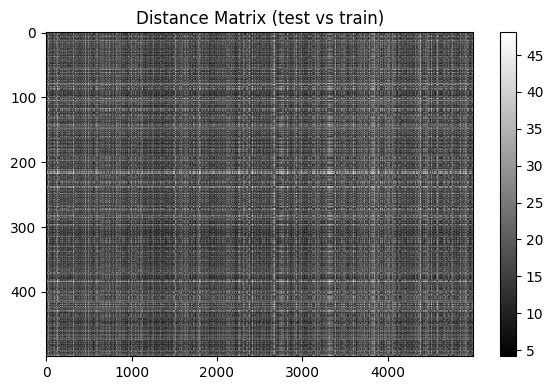

Saved distance matrix heatmap -> results/knn_distance_matrix.png


In [38]:
from src.k_nearest_neighbor import KNearestNeighbor
import os, matplotlib.pyplot as plt
os.makedirs('results', exist_ok=True)
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# 计算距离矩阵并可视化 + 自动保存
dists = classifier.compute_distances_no_loops(X_test)
plt.figure(figsize=(6,4))
plt.imshow(dists, aspect='auto', interpolation='nearest')
plt.title('Distance Matrix (test vs train)')
plt.colorbar()
plt.tight_layout()
plt.savefig('results/knn_distance_matrix.png', dpi=150)
plt.show()
print('Saved distance matrix heatmap -> results/knn_distance_matrix.png')

**Bonus question**: You can think what does this distance matrix means, why some rows or columns are visible brighter or darker? What's the behind true reason?

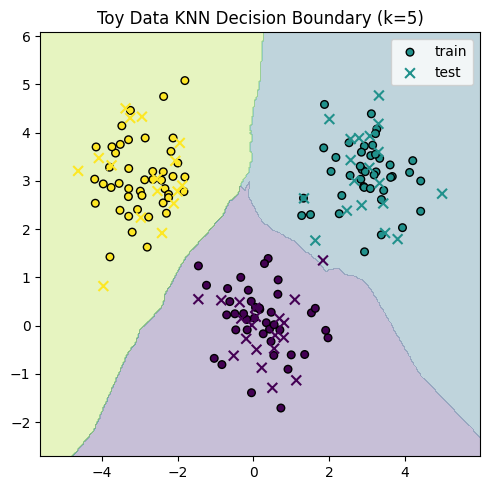

Saved decision boundary plot -> results/knn_plot.png


In [39]:
# Optional: 2D toy dataset decision boundary visualization (auto-save)
import numpy as np, matplotlib.pyplot as plt, os
from src.k_nearest_neighbor import KNearestNeighbor
os.makedirs('results', exist_ok=True)

def make_toy(n_per_class=60):
    centers = [(0,0),(3,3),(-3,3)]
    Xs, ys = [], []
    for idx,(cx,cy) in enumerate(centers):
        Xs.append(np.random.randn(n_per_class,2)*0.8 + np.array([cx,cy]))
        ys.append(np.full(n_per_class, idx))
    X = np.vstack(Xs); y = np.concatenate(ys)
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

X_toy, y_toy = make_toy()
split = int(0.7*len(X_toy))
X_tr, y_tr = X_toy[:split], y_toy[:split]
X_te, y_te = X_toy[split:], y_toy[split:]

knn_toy = KNearestNeighbor(); knn_toy.train(X_tr, y_tr)

k_vis = 5
x_min,x_max = X_toy[:,0].min()-1, X_toy[:,0].max()+1
y_min,y_max = X_toy[:,1].min()-1, X_toy[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min,x_max,300), np.linspace(y_min,y_max,300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn_toy.predict(grid, k=k_vis, num_loops=0).reshape(xx.shape)

plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, levels=len(np.unique(y_toy)), alpha=0.3, cmap='viridis')
plt.scatter(X_tr[:,0], X_tr[:,1], c=y_tr, cmap='viridis', edgecolor='k', s=30, label='train')
plt.scatter(X_te[:,0], X_te[:,1], c=y_te, cmap='viridis', marker='x', s=50, label='test')
plt.title(f'Toy Data KNN Decision Boundary (k={k_vis})')
plt.legend()
plt.tight_layout()
plt.savefig('results/knn_plot.png', dpi=160)
plt.show()
print('Saved decision boundary plot -> results/knn_plot.png')

k=1  -> accuracy=0.2740
k=3  -> accuracy=0.2720
k=3  -> accuracy=0.2720
k=5  -> accuracy=0.2780
k=5  -> accuracy=0.2780
k=7  -> accuracy=0.2740
k=7  -> accuracy=0.2740
k=9  -> accuracy=0.2680
k=9  -> accuracy=0.2680
k=11 -> accuracy=0.2620
k=11 -> accuracy=0.2620
k=13 -> accuracy=0.2660
Best k: 5
k=13 -> accuracy=0.2660
Best k: 5


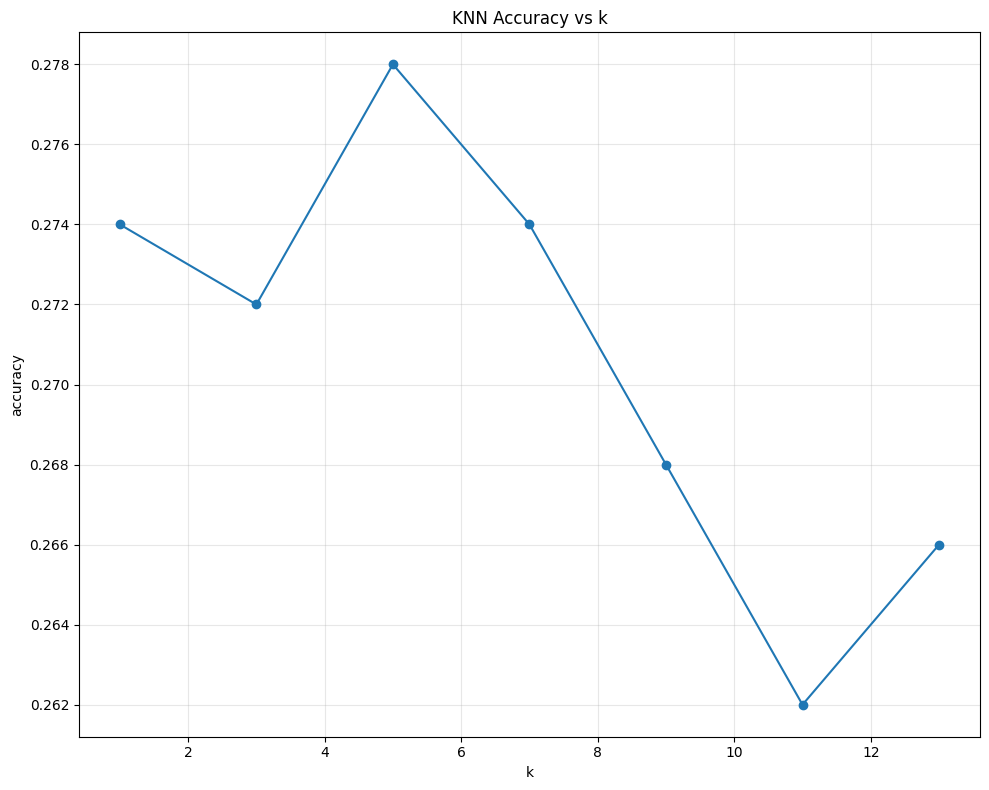

Saved accuracy curve -> results/knn_accuracy.png
Final accuracy with k=5: 0.2780
Saved metrics -> results/knn_metrics.json
Final accuracy with k=5: 0.2780
Saved metrics -> results/knn_metrics.json


In [40]:
# Predict with different k and compute accuracy (auto-save curve + final metrics)
import numpy as np, os, matplotlib.pyplot as plt, json
os.makedirs('results', exist_ok=True)

k_values = [1,3,5,7,9,11,13]
accuracies = []
for k in k_values:
    y_test_pred = classifier.predict(X_test, k=k, num_loops=0)
    num_correct = np.sum(y_test_pred == y_test)
    acc = num_correct / len(y_test)
    accuracies.append(acc)
    print(f'k={k:<2d} -> accuracy={acc:.4f}')

best_k = k_values[int(np.argmax(accuracies))]
print('Best k:', best_k)

plt.figure()
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k'); plt.ylabel('accuracy'); plt.title('KNN Accuracy vs k')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/knn_accuracy.png', dpi=160)
plt.show()
print('Saved accuracy curve -> results/knn_accuracy.png')

final_pred = classifier.predict(X_test, k=best_k, num_loops=0)
final_acc = (final_pred == y_test).mean()
print(f'Final accuracy with k={best_k}: {final_acc:.4f}')
# 保存数值指标到 JSON
metrics = {"best_k": int(best_k), "final_accuracy": float(final_acc)}
with open('results/knn_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)
print('Saved metrics -> results/knn_metrics.json')

Other distance functions are also acceptable, e.g., L1 distance, L0 distance, Lp distance

If possible, see how does KNN behave on the whole dataset?

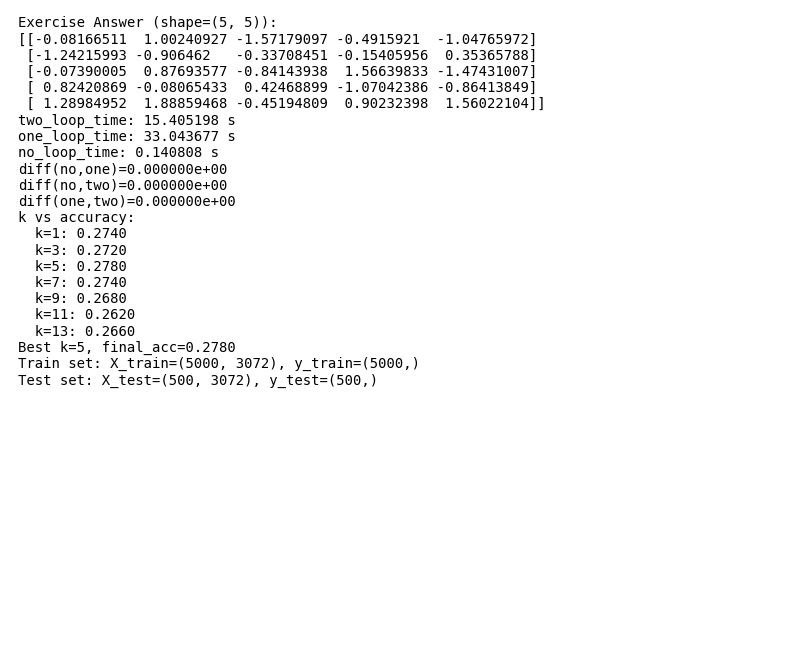

Saved NumPy answers summary -> results/numpy_answers.png


In [41]:
# 自动汇总并保存 NumPy 练习答案为图片
import os, inspect, textwrap, matplotlib.pyplot as plt, numpy as np
os.makedirs('results', exist_ok=True)

# 示例：假设前面练习中产生的关键变量 answer / samples / X_train 等
summary_lines = []

# 1. 显示某个练习的结果（若变量存在）
if 'answer' in globals():
    summary_lines.append('Exercise Answer (shape=%s):' % (answer.shape,))
    # 仅展示前几行
    preview = np.array2string(answer[:5], threshold=20)
    summary_lines.append(preview)

# 2. 展示距离实现用时（若变量存在）
for name in ['two_loop_time','one_loop_time','no_loop_time']:
    if name in globals():
        summary_lines.append(f'{name}: {globals()[name]:.6f} s')

# 3. 展示三种距离差异（若变量存在）
if all(v in globals() for v in ['no_loop_results','one_loop_results','two_loop_results']):
    diff_no_one = np.linalg.norm(no_loop_results - one_loop_results)
    diff_no_two = np.linalg.norm(no_loop_results - two_loop_results)
    diff_one_two = np.linalg.norm(one_loop_results - two_loop_results)
    summary_lines.append(f'diff(no,one)={diff_no_one:.6e}')
    summary_lines.append(f'diff(no,two)={diff_no_two:.6e}')
    summary_lines.append(f'diff(one,two)={diff_one_two:.6e}')

# 4. 展示 k 准确率列表（若变量存在）
if 'k_values' in globals() and 'accuracies' in globals():
    summary_lines.append('k vs accuracy:')
    summary_lines.extend([f'  k={k}: {acc:.4f}' for k,acc in zip(k_values, accuracies)])
if 'best_k' in globals() and 'final_acc' in globals():
    summary_lines.append(f'Best k={best_k}, final_acc={final_acc:.4f}')

# 5. 额外：数据集形状（若变量存在）
if 'X_train' in globals() and 'y_train' in globals():
    summary_lines.append(f'Train set: X_train={X_train.shape}, y_train={y_train.shape}')
if 'X_test' in globals() and 'y_test' in globals():
    summary_lines.append(f'Test set: X_test={X_test.shape}, y_test={y_test.shape}')

text = '\n'.join(summary_lines) if summary_lines else 'No summary data collected.'

# 渲染到图片
plt.figure(figsize=(8, max(2, len(summary_lines)*0.35)))
plt.axis('off')
plt.text(0.01, 0.99, text, va='top', ha='left', family='monospace', fontsize=10)
plt.tight_layout()
plt.savefig('results/numpy_answers.png', dpi=160)
plt.show()
print('Saved NumPy answers summary -> results/numpy_answers.png')